## Pitch Prediction Model

Import necessary packages and modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

### Data Cleaning and preprocessing
- Read .csv file from data cleaning notebook

In [2]:
df = pd.read_csv('data/final_dataset_modeling.csv', index_col=False)

In [3]:
df.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - SL - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,SL,5,0,1,0,0,9.0 - FB - called,14.0 - SL - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - SL - ball,9.0 - FB - called,14.0 - SL - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - CH - ball,14.0 - CH - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,CH,5,0,1,0,0,3.0 - FB - foul,14.0 - CH - ball,14.0 - CH - ball,2-2


- Dropping any specific data point that may be causing issues, 4-2 is not a valid `pitch_count` for our dataset

In [4]:
df_bi = df.drop(df[df['pitch_count'] == '4-2'].index)

- Remove any null values

In [5]:
df_bi.dropna(axis=0, inplace=True)

In [6]:
#Sanity Check
df_bi.isna().sum()

player_name            0
pitcher                0
batter                 0
stand                  0
pitch_type             0
pitch_number           0
outs_when_up           0
times_faced            0
XBH                    0
large_score_dif        0
recent_pitch           0
second_recent_pitch    0
third_recent_pitch     0
pitch_count            0
dtype: int64

Our multiclass dataset with 4 different pitch types was quite imbalanced. We made the decision to convert our data to binary classes and this ended up making our dataset much more balanced for modeling. 

We opted out of using synthetic data manipluation techniques like SMOTE because directly applying it to baseball pitch data could give misleading and counterproductive results. The synthetic samples generated by SMOTE don't take into account domain-specific constraints. For example, certain pitch combinations of velocity, break and location may be physically impossible for a pitcher to throw. The interpolated examples could introduce nonsensical pitches. More domain-aware techniques would likely be preferable.

We will instead go from multiclass classification to binary classification and use feature engineering with pipelines.

### First we will define functions to convert pitch_type from multiclass to binary classes!

In [7]:
def transform_pitch_types(column):
    """
    Transform specific pitch types in a column to 'OS'.
    'SL', 'CH', 'CB' are changed to 'OS', other values are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    # Mapping specific pitch types to 'OS'
    pitch_map = {'SL': 'OS', 'CH': 'OS', 'CB': 'OS'}

    # Using the map function to apply the transformation
    return column.map(lambda x: pitch_map.get(x, x))

In [8]:
def transform_pitch_types_in_string(column):
    """
    Transform specific substrings in a column to 'OS'.
    Substrings 'SL', 'CH', 'CB' are changed to 'OS', other parts of the string are left unchanged.

    Args:
    column (pd.Series): A pandas Series representing the column to be transformed.

    Returns:
    pd.Series: The transformed column.
    """
    def replace_substring(pitch):
        # Replace specific substrings with 'OS'
        for sub in ['SL', 'CH', 'CB']:
            pitch = pitch.replace(sub, 'OS')
        return pitch

    return column.apply(replace_substring)

- Making a new copy of the data before setting target and features

In [9]:
df_bi_clean = df_bi.copy()
df_bi_clean['pitch_type'] = transform_pitch_types(df_bi_clean['pitch_type'])
df_bi_clean['recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['recent_pitch'])
df_bi_clean['second_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['second_recent_pitch'])
df_bi_clean['third_recent_pitch'] = transform_pitch_types_in_string(df_bi_clean['third_recent_pitch'])

- Data for `pitch_type` column should now be split into binary classes, **FB** for fastball **OS** for offspeed.

In [10]:
#Sanity Check
df_bi_clean.head()

,player_name,pitcher,batter,stand,pitch_type,pitch_number,outs_when_up,times_faced,XBH,large_score_dif,recent_pitch,second_recent_pitch,third_recent_pitch,pitch_count
0,"Rodriguez, Grayson",680570,543760,R,FB,4,0,1,0,0,14.0 - OS - ball,2.0 - FB - foul,14.0 - FB - ball,2-1
1,"Rodriguez, Grayson",680570,543760,R,OS,5,0,1,0,0,9.0 - FB - called,14.0 - OS - ball,2.0 - FB - foul,2-2
2,"Rodriguez, Grayson",680570,543760,R,FB,6,0,1,0,0,14.0 - OS - ball,9.0 - FB - called,14.0 - OS - ball,3-2
3,"Rodriguez, Grayson",680570,608369,L,FB,4,0,1,0,0,14.0 - OS - ball,14.0 - OS - ball,4.0 - FB - called,2-1
4,"Rodriguez, Grayson",680570,608369,L,OS,5,0,1,0,0,3.0 - FB - foul,14.0 - OS - ball,14.0 - OS - ball,2-2


#### Set target variable and columns to include before training and splitting the data

In [11]:
# X contains the features
# y contains the target

X = df_bi_clean.drop(columns=['player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_number'])
y = df_bi_clean['pitch_type']

#### Initialize OneHotEncoder and perform `train_test_split`
- The `OneHotEncoder` converts categorical features into one-hot encoded features
- `sparse=False` means return a numpy array instead of a sparse matrix
- `handle_unknown='error'` will raise an error if the dataset contains a categorical value that was not seen in the training data
- `drop='first'` will drop the first category for each feature to avoid collinearity

In [12]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='error', drop='first')

# Split the encoded data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Create dummy model
- We will use a dummy baseline model to compare the results to our final model.

In [13]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='most_frequent')

In [14]:
# fit dummy model
dc.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
#Score for dummy model
dc.score(X_test, y_test)

0.540991461927165

We need to create a `ColumnTransformer` to encode all categorical columns before we create pipeline for Modeling and Evaluation. The end result is the categorical columns are one-hot encoded, and the other columns are left as-is.

The ColumnTransformer allows us to specify different transformers to different columns, handling both categorical and numerical data.

In [16]:
from sklearn.compose import ColumnTransformer

# Create a column transformer to apply encoding only to the categorical columns
preprocessor = ColumnTransformer(transformers=
                                 [('cat', ohe, [0, 1, 2, 3, 4, 5, 6, 7, 8])],
                                 remainder='passthrough')

In [17]:
preprocessor.fit(X_train)

preprocessor.transform(X_train).shape

(68866, 333)

In [18]:
X_train_transformed = preprocessor.transform(X_train)

In [18]:
preprocessor.transform(X_test).shape

(22956, 333)

### Pipeline
- We will create a pipeline for **MLPClassifier**, a neural network from sklearn. MLPClassifier known as the Multi-layer Perceptron classifier is useful for classification tasks for data that contain nonlinear relationships.

In [20]:
from sklearn.neural_network import MLPClassifier

#Build pipeline to train MLP
pipe = Pipeline([('ct', preprocessor), ('mlp', MLPClassifier())])

- We opted to use `RandomizedSearchCV` here instead of `GridSearchCV` that we used in our other training runs. Random search will look for the best hyperparameters that we set in the `param_distribution` dictionary. MLPclassifier has hidden layers that we can't really interpret but we use the funnel stucture with 3 layers that starts and end with smallest layers eg. (10, 30, 10)

- `RandomizedSearchCV` which will implement the fit and score method. The hyper parameters like the solver  **'sgd'** is an optimized version of gradient descent known as stochastic gradient descent.
- Cross Validation will be done in 5 folds and `randome_state=42` to maintain consistency throughout our process.

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'mlp__hidden_layer_sizes': [(10,30,10), (50,100,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['sgd'],
    'mlp__alpha': [0.0001, .001],
    'mlp__tol': [1e-4, 1e-5, 1e-6]
}

# Create a RandomizedSearchCV object
clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, n_iter=50, verbose=3, cv=5, random_state=42, n_jobs=-1)

# Fit the model
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/dreampy/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 120 | elapsed:  7.9min remaining:   25.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  8.2min finished
/home/dreampy/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             sparse=False),
                                                                               [0,
                                                                                1,
                                                                                2,
                                                                                3,
                                                                                4,
                                                                                5,
                                   

In [22]:
# Print the best parameters and score
best_parameters = clf.best_params_
best_score = clf.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'mlp__tol': 1e-05, 'mlp__solver': 'sgd', 'mlp__hidden_layer_sizes': (10, 30, 10), 'mlp__alpha': 0.0001, 'mlp__activation': 'relu'}
Best Score: 0.6007319398602816


- Generate `classification_report` we are looking at **accuracy** here for our pitch predicition. 

In [23]:
from sklearn.metrics import classification_report

# Step 2: Make Predictions
y_pred = clf.predict(X_test)

# Step 3: Generate Classification Report
report = classification_report(y_test, y_pred)

The **accuracy** in our report is 0.60, meaning that the model correctly predicts the pitch type 60% of the time across both classes ont the test data.

The reason why accuracy might be considered most important in this context could be due to the nature of evaluating baseball pitches. If you're analyzing pitches in a game situation, we would want to know, in a general sense, how often you can expect the model to correctly identify a pitch. Higher accuracy means that the model's predictions are more often correct, which is crucial for applications like real-time decision-making during a game or analyzing a pitcher's tendencies.

Assuming that fastballs are the positive class, we had a lower precision and higher recall score for fastballs. But for offspeed pitches precision had a higher score than recall.

In [24]:
print(report)

              precision    recall  f1-score   support

          FB       0.64      0.60      0.62     12419
          OS       0.56      0.59      0.58     10537

    accuracy                           0.60     22956
   macro avg       0.60      0.60      0.60     22956
weighted avg       0.60      0.60      0.60     22956



### Display `ConfusionMatrix`

- We display a confusion matrix to display the results between our predictions

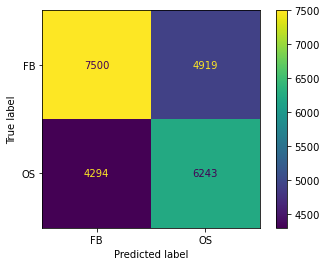

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions
y_pred = clf.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

### ROC curve and roc_auc score evaluating our tpr (true positive rate) and fpr (false positive rate)

In [33]:
from sklearn.metrics import roc_auc_score

# Print ROC AUC Score
roc_auc = roc_auc_score(y_test, y_score)

print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.6404586851391494


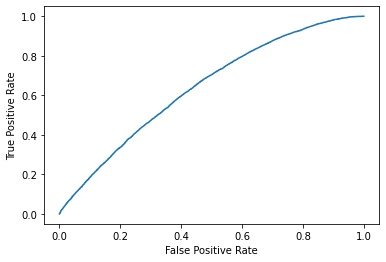

In [26]:
from sklearn.metrics import RocCurveDisplay, roc_curve

# clf is our classifier and it supports predict_proba()
y_score = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class

# Compute and plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Looking at the provided ROC curve, it rises fairly quickly towards the top-left corner, which suggests that the model has a good measure of separability. It does not reach close to the perfect score, but it appears to perform better than a random guess (which would be a diagonal line from the bottom left to the top right). ROC AUC Score: 0.6404586851391494 which suggest there is room for improvement.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### Pipeline to pull out features using RandomForestClassifier
- Because we are unable to pull features from the neural network we will create another pipeline using another machine learning model that we had previously trained with our multiclass dataset. 
- This time we will run a `GridSearchCV` where we can be more thorough to iterate through to search for hyperparameters

In [28]:
rf_pipe = Pipeline([('ct', preprocessor), ('rf', RandomForestClassifier())])

In [29]:
grid_search_rf = {'rf__max_depth': [None, 25, 35],
       'rf__class_weight': ['balanced', 'balanced_subsample']}

In [30]:
rf_pipe = GridSearchCV(estimator=rf_pipe, param_grid=grid_search_rf, verbose=3, n_jobs=-1)
rf_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:   26.7s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:   34.0s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   39.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.9s finished


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
      

### Pulling top 20 feature importances out of our model

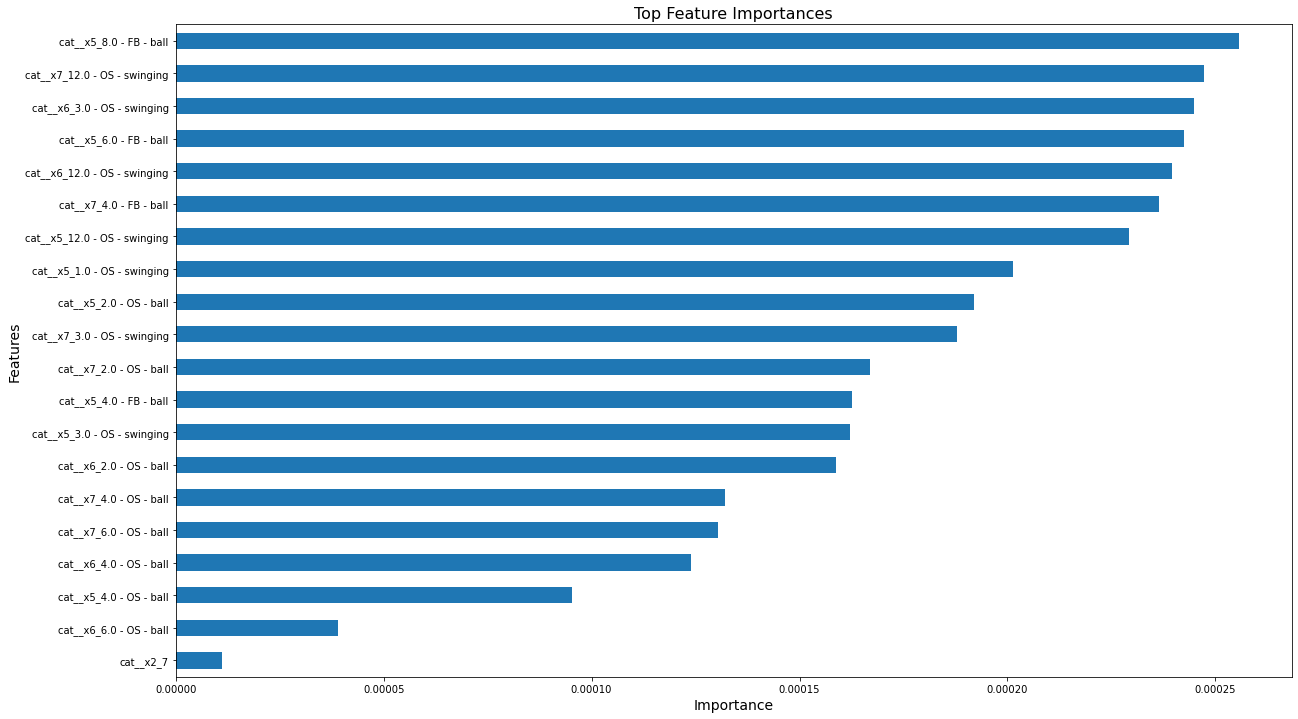

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# rf_pipe is trained GridSearchCV object
best_rf = rf_pipe.best_estimator_

# Access the ColumnTransformer from the pipeline
column_transformer = best_rf.named_steps['ct']

# Get the feature names after one-hot encoding and any 'passthrough' features
encoded_feature_names = column_transformer.get_feature_names()

# Extract feature importances
importances = best_rf.named_steps['rf'].feature_importances_

# Create a pandas Series with the importances and encoded feature names
feature_importances = pd.Series(importances, index=encoded_feature_names)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=True)

n = 20  # for example, the top 20 features
top_sorted_importances = sorted_importances.head(n)


# Create a horizontal bar plot
plt.figure(figsize=(20,12))  
top_sorted_importances.plot(kind='barh')  
plt.title('Top Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()
plt.savefig('feature_importances_2024.png', dpi=300)

### Training and cross validating another model XGBoost

In [19]:
# Preprocessor applies the transformations
# XGBoost model used for classification

import xgboost as xgb

model = xgb.XGBClassifier()

xgb_pipe = Pipeline([
    ('ct', preprocessor),
    ('xgboost', model)  
])

# Fit the pipeline  
xgb_pipe.fit(X_train, y_train)  

# Apply the pipeline to test data
y_pred = xgb_pipe.predict(X_test)

# Evaluate pipeline performance
accuracy = xgb_pipe.score(X_test, y_test)
print(accuracy)

0.5954870186443632


#### Run a GridSearchCV on XGBoost the pipeline

Scoring metric used here is ROC AUC

In [29]:
params = {
    'xgboost__colsample_bytree': [0.3, 0.5, 0.7],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__min_child_weight': [1, 3, 5],
    'xgboost__gamma': [0, 0.1, 0.2],
    'xgboost__subsample': [0.7],
    'xgboost__learning_rate': [0.1],
    'xgboost__n_estimators': [500],

}

xgb_grid = GridSearchCV(xgb_pipe, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=4)  

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 28.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 35.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                              

In [24]:
print("Best Parameters:", xgb_grid.best_params_)
print("Best Score:", xgb_grid.best_score_)

Best Parameters: {'xgboost__colsample_bytree': 0.3, 'xgboost__gamma': 0, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__min_child_weight': 5, 'xgboost__n_estimators': 500, 'xgboost__subsample': 0.7}
Best Score: 0.6442422174018305


Now let's use accuracy as the scoring metric to compare it to our **MLPclassifier**

In [26]:
# Define hyperparameter distro
best_params = {
    'xgboost__colsample_bytree': [0.3],
    'xgboost__max_depth': [7],
    'xgboost__min_child_weight': [5],
    'xgboost__gamma': [0],
    'xgboost__subsample': [0.7],
    'xgboost__learning_rate': [0.1],
    'xgboost__n_estimators': [500],

}
# Create object 
xgb_grid = GridSearchCV(xgb_pipe, best_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=4)  

# Fit the model
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8])])),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                              

In [28]:
print("Best Score:", xgb_grid.best_score_)

Best Score: 0.5981616947807863


In [27]:
from sklearn.metrics import classification_report

best_model = xgb_grid.best_estimator_

# Make predictions
xgb_preds = best_model.predict(X_test)

# Print classification report
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

          FB       0.62      0.67      0.64     12419
          OS       0.57      0.52      0.54     10537

    accuracy                           0.60     22956
   macro avg       0.60      0.59      0.59     22956
weighted avg       0.60      0.60      0.60     22956



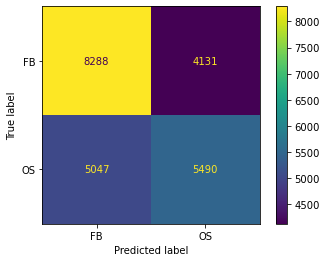

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions
y_pred_xgb = xgb_grid.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(cm, display_labels=xgb_grid.classes_).plot()

### Interpreting Results between MLPClassifier and XGBoost models

Our `XGBoost` model has a slightly lower accuracy score but a higher f1-score than our `MLPClassifier`. Models perform similiarly, with tradeoffs between precision and recall for the two classes. The `f1-score` is the harmonic mean of precision and recall. A higher f1-score indicates a better balance between precision and recall. For fastballs XGBoost has a higher f1-score, while for the offspeed, MLPClassifier has a higher f1-score.

## Conclusions

As previously mentioned accuracy is the metric we are evaluating on for this particular classification between **FB** and **OS** pitches. Our `MLPClassifier` will possibly perform better in a real world pitch sequence prediction model if deployed properly. With further tuning and tweaking, XGBoost could possible be another model to use for deployment. Analyzing a pitcher's tendencies and predicting the next pitch is quite a complex task. Further investigation and feature engineering could be explored to optimize these models for deployment in MLB games. 